# Modal analysis of a 2D-beam

Notebook to introduce Modal analysis in FEniCS.

What will be shown here is a 2D-beam clamped on the left hand side. 

In [1]:
from petsc4py import PETSc
from slepc4py import SLEPc
from dolfin import *
% matplotlib inline
import mshr
from MA_tools import get_interior_index_set, reduce_matrix, extract_modes
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

The beam is modeled by a rectangular domain that is meshed using <code>mshr</code>. The left hand side and right hand side of the domain are defined to apply the clamped boundary condition and loading.

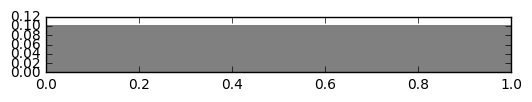

In [2]:
# Create mesh
height = 0.1
length = 1.000

P0 = Point(0., 0.)
P1 = Point(length, height)
domain = mshr.Rectangle(P0, P1)

dens = 300
mesh = mshr.generate_mesh(domain, dens)

# Mark boundary subdomains
class BoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], 0.))
    
class BoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], length))

# set boundary markers
#boundary_markers = FacetFunction('size_t', mesh)
left = BoundaryLeft()
right = BoundaryRight()
#left.mark(boundary_markers, 0)
#right.mark(boundary_markers, 1)
#ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers)


plt.figure()
plot(mesh)
plt.show()

The material properties of steel are used in this example. Hooke's law is used for linear elasticity and plane stress.

In [3]:
# Mass density
rho = 7.8e4

# Elasticity parameters
E, nu = 2.1e9, 0.3

# Lamé constants 
mu    = Constant(E / (2.0*(1.0 + nu)))
lmbda = Constant(E*nu / ((1.0 + nu)*(1.0 - 2.0*nu)))

# Define strain and stress
# Using the plane stress hypothesis
def epsilon(u):
    return sym(nabla_grad(u))

def sigma(u):
    return 2*mu*sym(grad(u)) + lmbda*tr(sym(grad(u)))*Identity(len(u))

# Define problem 
Using the following function the mass, elastic and geometric stiffness matrices are computed along with the boundary conditions defined and the function space

In [4]:
def setup_problem(dens):
    mesh = mshr.generate_mesh(domain, dens)

    # Create function space
    V = VectorFunctionSpace(mesh, "Lagrange", 1)

    # Create test and trial functions, and source term
    u = TrialFunction(V)
    v = TestFunction(V)
    
    # Define boundary conditions
    bc = DirichletBC(V, Constant((0.0, 0.0)), left)
    
    # Applied force
    P_applied = -1.

    # Define bilinear forms of the elastic tangent and geometric stiffness components
    a_el = inner(sigma(u), epsilon(v))*dx 
    a_geom = P_applied*inner(grad(v[0]),grad(u[0]))*dx
    
    # Assemble matrices
    K_el = PETScMatrix()
    K_geom = PETScMatrix()
    M_mat = PETScMatrix()
    F_vec = PETScVector()

    Le = dot(Constant((0., 0.)), v)*dx # Dummy linear variational form

    assemble_system(a_el, Le, bc, A_tensor=K_el, b_tensor=F_vec)
    assemble_system(a_geom, Le, bc, A_tensor=K_geom, b_tensor=F_vec)
    assemble_system(rho*dot(u,v)*dx, Le, bc, A_tensor=M_mat, b_tensor=F_vec)
    return M_mat, K_el, K_geom, bc, V

In [5]:
# Set up problem
mesh_density = 75
M_mat, K_el, K_geom, bc, V = setup_problem(mesh_density)

# Construct Jacobian matrix

$$
\mathbf{M}\dot{y} + \mathbf{K}x = \mathbf{F} \\
\mathbf{A}\dot{x} - \mathbf{A}y = 0
$$
Where $\mathbf{A}$ can be chosen freely.

Rewriting in matrix form:
$$
\begin{bmatrix}
0 & \mathbf{I} \\
\mathbf{A} & 0
\end{bmatrix}  \begin{pmatrix} \dot{x} \\
\dot{y}  \end{pmatrix} = \begin{bmatrix} -\mathbf{M}^{-1}\mathbf{K} & \mathbf{0} \\
\mathbf{0} & \mathbf{A}
\end{bmatrix} 
\begin{pmatrix} x \\ y \end{pmatrix}
+ \begin{pmatrix} \mathbf{M}^{-1}\mathbf{F} \\
\mathbf{0} \end{pmatrix}
$$


$$
\mathbf{J} = \begin{bmatrix}
-\mathbf{M}^{-1}\mathbf{K} & \mathbf{0}   \\
\mathbf{0} & \mathbf{A}
\end{bmatrix}
$$

Or to avoid the inversion of $\mathbf{M}$, we keep $\mathbf{M}$ on the left hand side and we choose $\mathbf{A}=\mathbf{M}$ to make the left hand side symmetric:
$$
\begin{bmatrix}\mathbf{0} & \mathbf{M} \\
\mathbf{M} & \mathbf{0}
\end{bmatrix}
\begin{pmatrix} \dot{y} \\
\dot{x} \end{pmatrix} = \begin{bmatrix} -\mathbf{K} & \mathbf{0} \\
\mathbf{0} & \mathbf{M} 
\end{bmatrix} 
\begin{pmatrix} y \\ x \end{pmatrix}
+ \begin{pmatrix} \mathbf{F} \\
\mathbf{0} \end{pmatrix}
$$

In [6]:
# Find indices of internal domain
index_set_not_bc = get_interior_index_set(bc, V)

# Reduce matrices
K_geom_reduced = reduce_matrix(K_geom, index_set_not_bc)
K_el_reduced = reduce_matrix(K_el, index_set_not_bc)
M_mat_reduced = reduce_matrix(M_mat, index_set_not_bc)

# Get petsc matrices for stiffness and mass
Kg = K_geom_reduced.mat()
K0 = K_el_reduced.mat()
M0 = M_mat_reduced.mat()

# Set empty matrix
null = PETSc.Mat()

## Testing the SLEPc4py eigenvalue solver:

In [7]:
# WIP: formulate eigensolver using slepc directly based on: https://github.com/MiroK/cbc.block-eig/blob/master/stokes.py

# set number of eigenvalues to 10
neigs = 10

# Setup the eigensolver
solver = SLEPc.EPS().create()
solver.setOperators(K0, M0)
solver.setType(solver.Type.GD)
solver.setDimensions(neigs, PETSc.DECIDE)
solver.setWhichEigenpairs(solver.Which.SMALLEST_REAL)
solver.setProblemType(SLEPc.EPS.ProblemType.GHEP)

preconditioner = solver.getST().getKSP().getPC()
preconditioner.setType("lu")

solver.setFromOptions()

# Solve the eigensystem
solver.solve()

print('System size: %i' % K0.size[0])
its = solver.getIterationNumber()
print('Number of iterations of the method: %i' % its)
nconv = solver.getConverged()
print('Number of converged eigenpairs: %d' % nconv)
if nconv > 0:
    print(np.array([solver.getEigenvalue(i).real for i in range(nconv)]))

System size: 3036
Number of iterations of the method: 87
Number of converged eigenpairs: 10
[  3.05785499e+02   1.09479618e+04   7.33768850e+04   7.54531049e+04
   2.47449519e+05   5.72331042e+05   6.58510778e+05   1.07933046e+06
   1.78649446e+06   1.81823409e+06]


### Try all solver types: ###

First try all solvers on the classic eigenvalue problem $\mathbf{K}\phi = \lambda \mathbf{M} \phi $:

In [8]:
import time
soltypes = ['POWER', 'SUBSPACE', 'ARNOLDI', 'LANCZOS', 'KRYLOVSCHUR',
            'GD', 'JD', 'RQCG', 'LOBPCG', 'CISS'] 

pctypes_long = ["none", "jacobi", "sor", "lu", "bjacobi", "mg", "eisenstat", "ilu", "icc", "asm", 
                "gasm", "ksp", "spai", "nn", "cholesky", "pbjacobi", "mat", "hypre", "parms", "tfs",
                "ml", "galerkin", "exotic", "cp", "bfbt", "lsc", "pfmg", "syspfmg", "svd", "gamg", 
                "chowiluviennacl", "rowscalingviennacl", "saviennacl", "bddc", "kaczmarz", "telescope"]

pctypes = ["jacobi", "sor", "lu", "bjacobi", "ilu", "icc", "asm", "gasm", "gamg", "cholesky"]

# fieldsplit preconditioner seems useful for block matrices so you can set a preconditioner for each block

In [9]:
# set number of eigenvalues to 10
neigs = 10
print('System size: %i' % K0.size[0])

t00 = int(round(time.time() * 1000))

time_series = []
algorithm_series = []

for prcndtn in pctypes:
    
    preconditioner = PETSc.KSP().create().getPC()
    preconditioner.setType(prcndtn)

    
    for slvr in soltypes:
        t0 = int(round(time.time() * 1000))
        slvr_str = "".join(["solver.Type.", slvr])
        
        # Setup the eigensolver
        solver = SLEPc.EPS().create()
        solver.setOperators(K0, M0)
        solver.setDimensions(neigs, PETSc.DECIDE)
        solver.setWhichEigenpairs(solver.Which.SMALLEST_REAL)
        solver.setProblemType(SLEPc.EPS.ProblemType.GHEP)
    
        # Set solver type
        solver.setType(eval(slvr_str))
        solver.setFromOptions()

        # Solve the eigensystem
        try: 
            solver.solve()
            st = int(round(time.time() * 1000)) - t0
            print(''.join(["Time elapsed using ", slvr , " and ", prcndtn, ":   ", str(st), ' ms']))
            
            its = solver.getIterationNumber()
            print('   Number of iterations of the method: %i' % its)
            nconv = solver.getConverged()
            print('   Number of converged eigenpairs:     %d' % nconv)
            if nconv == 10.:
                time_series.append(st)
                algorithm_series.append(''.join([slvr , " and ", prcndtn]))
        except:
            st = int(round(time.time() * 1000)) - t0
            print(''.join(["FAILED: trying to use ", slvr , " and ", prcndtn, ": ", str(st), ' ms']))
        solver.destroy()
print("finished")
print(''.join(["Total time elapsed: ", str(int(round(time.time() * 1000)) - t00), ' ms']))
print(''.join([algorithm_series[np.argmin(time_series)], " is the fastest combination in this case"]))

System size: 3036
FAILED: trying to use POWER and jacobi: 1 ms
FAILED: trying to use SUBSPACE and jacobi: 0 ms
Time elapsed using ARNOLDI and jacobi:   2427 ms
   Number of iterations of the method: 379
   Number of converged eigenpairs:     0
Time elapsed using LANCZOS and jacobi:   2754 ms
   Number of iterations of the method: 379
   Number of converged eigenpairs:     0
Time elapsed using KRYLOVSCHUR and jacobi:   1246 ms
   Number of iterations of the method: 379
   Number of converged eigenpairs:     0
Time elapsed using GD and jacobi:   2322 ms
   Number of iterations of the method: 6072
   Number of converged eigenpairs:     0
Time elapsed using JD and jacobi:   230 ms
   Number of iterations of the method: 18
   Number of converged eigenpairs:     1
Time elapsed using RQCG and jacobi:   83938 ms
   Number of iterations of the method: 7
   Number of converged eigenpairs:     1
Time elapsed using LOBPCG and jacobi:   2053 ms
   Number of iterations of the method: 2024
   Number 

In [12]:
algorithm_series

['JD and jacobi',
 'RQCG and jacobi',
 'JD and sor',
 'RQCG and sor',
 'JD and lu',
 'RQCG and lu',
 'JD and bjacobi',
 'RQCG and bjacobi',
 'JD and ilu',
 'RQCG and ilu',
 'JD and icc',
 'RQCG and icc',
 'JD and asm',
 'RQCG and asm',
 'JD and gasm',
 'RQCG and gasm',
 'JD and gamg',
 'RQCG and gamg',
 'JD and cholesky',
 'RQCG and cholesky']